In [2]:
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower')
import helper
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from librosa import note_to_hz as hz
from onset_detection import detected_samples
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import helper
import numpy as np
from librosa import note_to_hz as hz
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def detected_samples(path='/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/beethoven.wav', sample_length=2000, offset=500, show=False, delta=0.05, num_samples=None, normalise=True):
    """
    Returns an array of numpy arrays for each detected onset note
    """
    sample_rate, data = wav.read(path)
    data = data.astype(np.float64) 
    if num_samples is not None:
        data = data[:num_samples]
    onset_times = librosa.onset.onset_detect(
        y=data, post_avg=5, wait=4,  sr=sample_rate, units='time', delta=delta)  # delta=0.15, wait=5, pre_avg=0, post_avg=5, pre_max=5, post_max=10,
    onset_numbers = onset_times * sample_rate

    sample_data = []
    for i in range(len(onset_numbers)):
        sample = data[int(onset_numbers[i]+offset):int(onset_numbers[i] + offset + sample_length)]
        if normalise is True:
            sample = helper.power_normalise(sample)/20
        sample_data.append(sample)
    if show is True:
        print("here")
        audio_duration = len(data)/sample_rate
        time_samples = np.linspace(0, audio_duration, len(data))
        helper.plot_audio(time_samples, data)
        for time in onset_times:
            plt.vlines(time + offset/sample_rate, ymin=-
                       25000, ymax=25000, colors='blue', zorder=2,linewidths=1)
            # plt.vlines(time + offset/sample_rate + sample_length /
            #            sample_rate, ymin=-25000, ymax=25000, colors='pink', zorder=2, linewidths=1)
    return sample_data, sample_rate, onset_times+500/44100


here


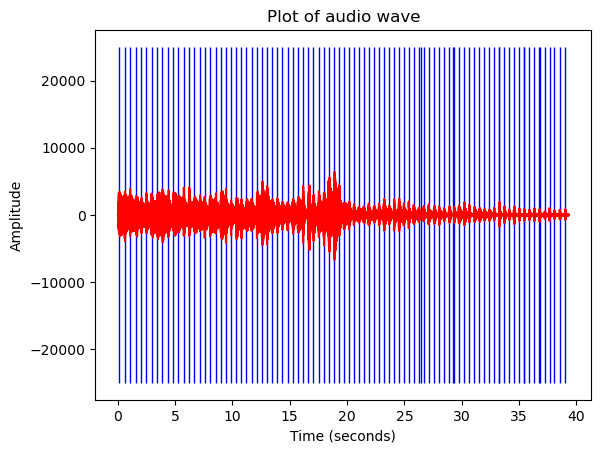

In [6]:
wav_file = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/round 2/chromatic.wav'
sample_rate, data = wav.read(wav_file)
# print(type(data))
sample_data, sample_rate, onset_times  = detected_samples(wav_file, sample_length=700, offset=0, show=True, delta=0.05,num_samples=1900000,normalise=False)
time_samples = np.linspace(
    0, len(sample_data[0])/sample_rate, len(sample_data[0]))

In [7]:
indices = []
for i in range(len(onset_times)-1, 0, -1):
    diff = onset_times[i]-onset_times[i-1]
    if diff < 0.22:
        indices.append(i)

print(indices)

    


[87, 83, 77, 67, 59]


In [8]:

sample_data = [element for index, element in enumerate(
    sample_data) if index not in indices]
print(len(sample_data))


88


In [17]:
M=9
T=0.465
v=2.37
notes = ["A0", "A#0", "B0", "C1", "C#1", "D1", "D#1", "E1", "F1", "F#1", "G1", "G#1", "A1", 
 "A#1", "B1", "C2", "C#2", "D2", "D#2", "E2", "F2", "F#2", "G2", "G#2", "A2",
 "A#2", "B2", "C3", "C#3", "D3", "D#3", "E3", "F3", "F#3", "G3", "G#3", "A3",
 "A#3", "B3", "C4", "C#4", "D4", "D#4", "E4", "F4", "F#4", "G4", "G#4", "A4",
 "A#4", "B4", "C5", "C#5", "D5", "D#5", "E5", "F5", "F#5", "G5", "G#5", "A5",
 "A#5", "B5", "C6", "C#6", "D6", "D#6", "E6", "F6", "F#6", "G6", "G#6", "A6",
 "A#6", "B6", "C7", "C#7", "D7", "D#7", "E7", "F7", "F#7", "G7", "G#7", "A7",
 "A#7", "B7", "C8"]

sigma=1/500000

f_base = 27.5
frequencies = [f_base * (2 ** (1/12)) ** i for i in range(len(sample_data))]

In [36]:
# Frequency calculation for circles of fifths starting from 27.5 Hz


# Prepare to store the results
M_values = range(1, 16)  # M from 1 to 15
results = np.zeros((len(M_values), len(sample_data)))

# Compute LMLs for each combination of M and sample_data index
for i, M in enumerate(M_values):
    for j in range(len(sample_data)):
        results[i, j] = -helper.stable_nlml(time_samples, sample_data[j], M=M, normalised=False, f=[frequencies[j]], T=T, v=v)


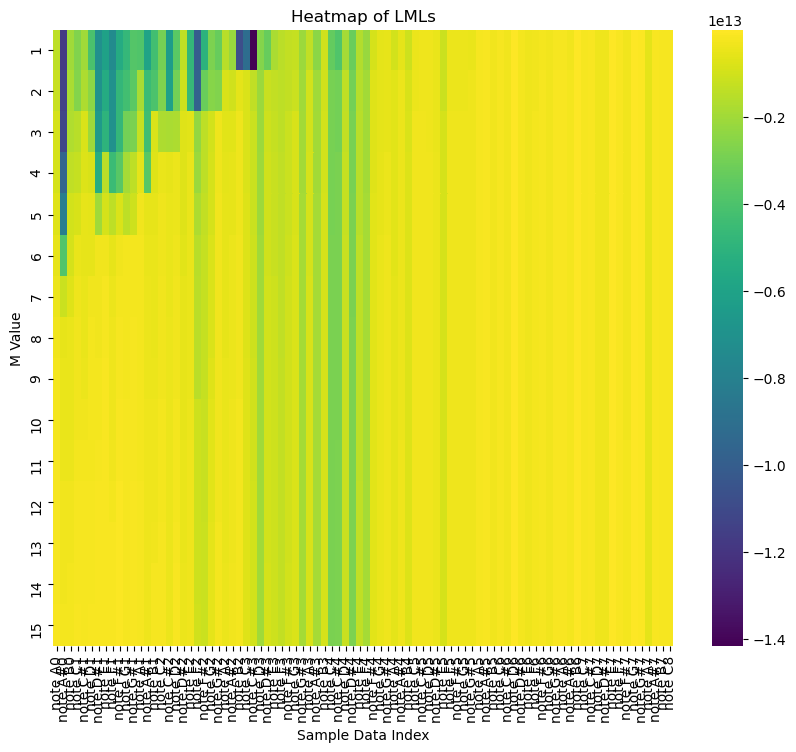

In [38]:

# Plotting the heatmap without annotations
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=False, cmap="viridis", xticklabels=[f"note {notes[i]}" for i in range(len(sample_data))], yticklabels=M_values)
plt.title("Heatmap of LMLs")
plt.xlabel("Sample Data Index")
plt.ylabel("M Value")
plt.show()

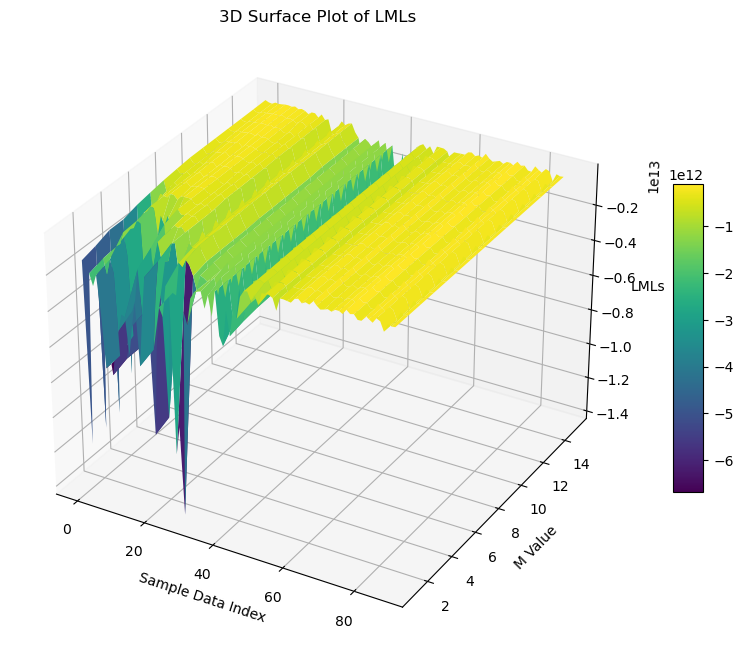

In [39]:

# Sample data setup (assuming 'results' is already computed)
M_values = np.arange(1, 16)  # M from 1 to 15
sample_data_indices = np.arange(len(sample_data))  # Indices of your sample data

# Create meshgrid
X, Y = np.meshgrid(sample_data_indices, M_values)

# Set up a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, results, cmap='viridis')

# Labels and title
ax.set_xlabel('Sample Data Index')
ax.set_ylabel('M Value')
ax.set_zlabel('LMLs')
ax.set_title('3D Surface Plot of LMLs')

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()

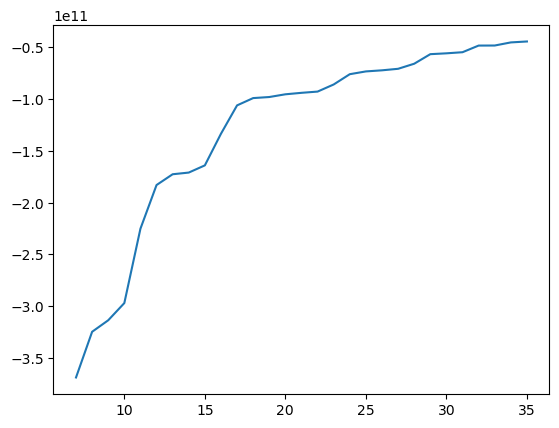

In [18]:
# Now looking at one frequency:
n = 3
data = sample_data[n]
LMLs = []
Ms = np.arange(7, 36, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=1/500000000, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

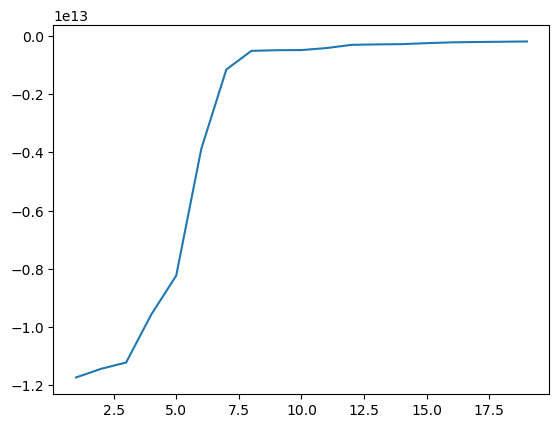

In [19]:
# Now looking at one frequency:
n = 1
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 20, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

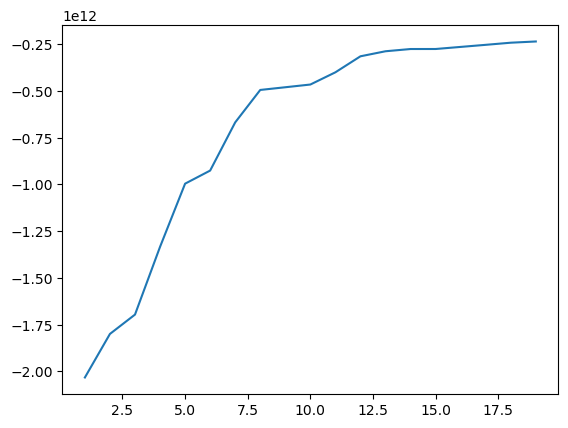

In [20]:
# Now looking at one frequency:
n = 2
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 20, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

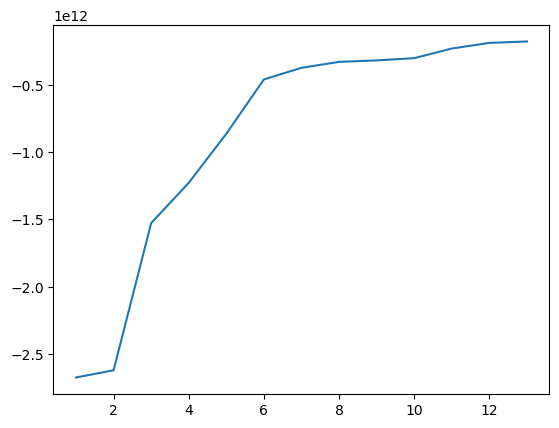

In [21]:
# Now looking at one frequency:
n = 3
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

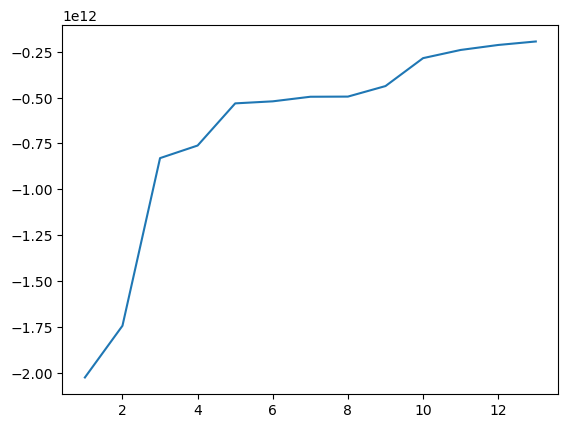

In [22]:
# Now looking at one frequency:
n = 4
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

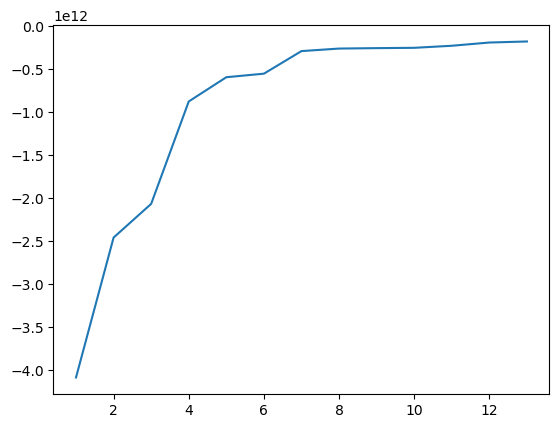

In [23]:
# Now looking at one frequency:
n = 5
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

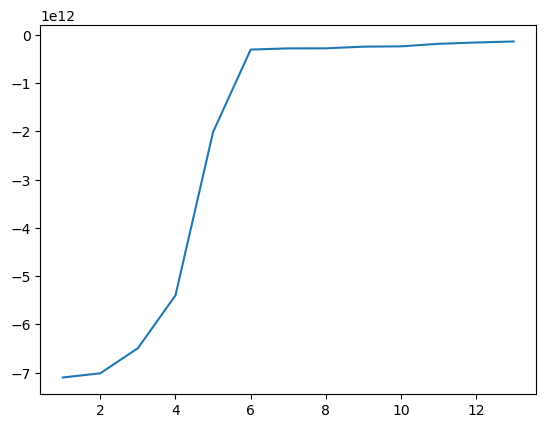

In [24]:
# Now looking at one frequency:
n = 6
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

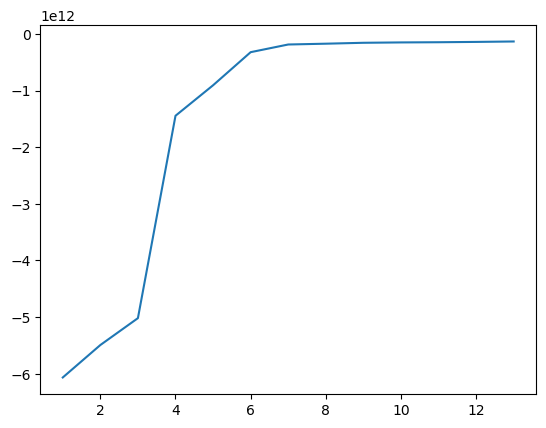

In [27]:
# Now looking at one frequency:
n = 7
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

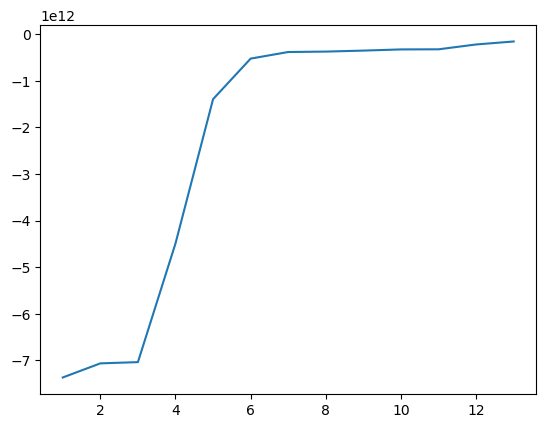

In [28]:
# Now looking at one frequency:
n = 8
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

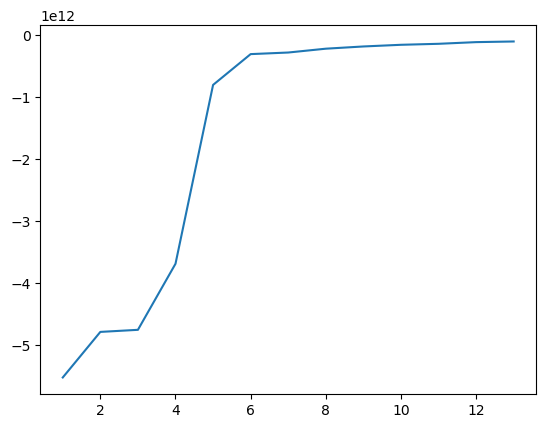

In [29]:
# Now looking at one frequency:
n = 9
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

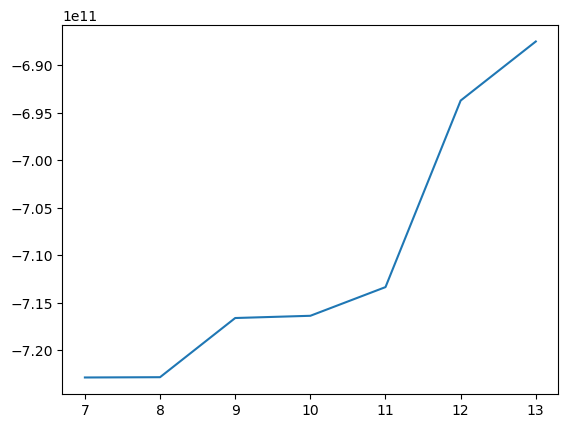

In [33]:
# Now looking at one frequency:
n = 27
data = sample_data[n]
LMLs = []
Ms = np.arange(7, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

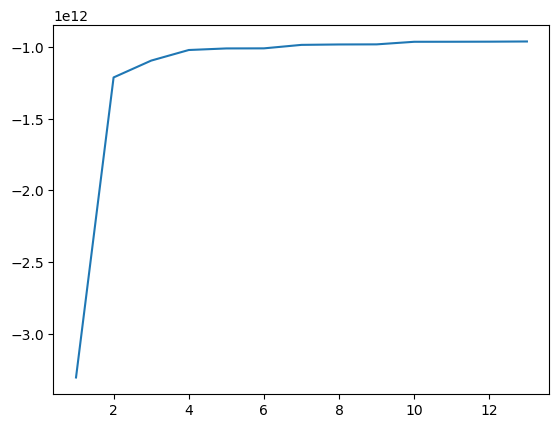

In [31]:
# Now looking at one frequency:
n = 30
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()

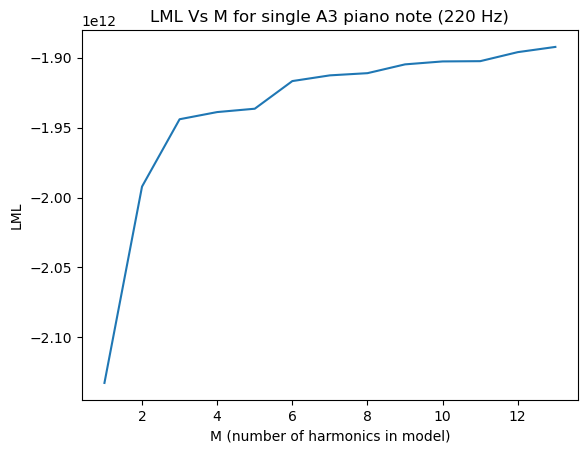

In [39]:
# Now looking at one frequency:
n = 3
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.title("LML Vs M for single A3 piano note (220 Hz)")
plt.xlabel("M (number of harmonics in model)")
plt.ylabel("LML")
plt.plot( Ms,LMLs)
plt.show()z


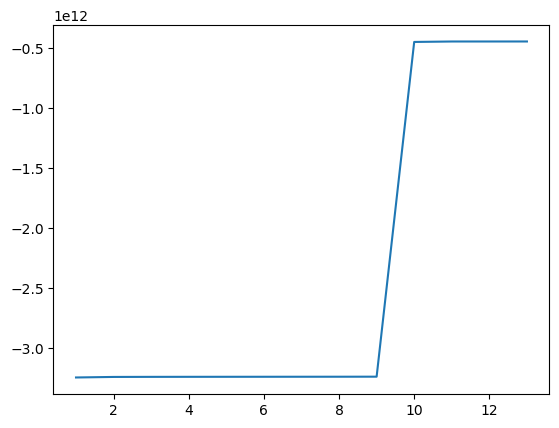

In [33]:
# Now looking at one frequency:
n = 12
data = sample_data[n]
LMLs = []
Ms = np.arange(1, 14, 1)
for m in Ms:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=m, sigma_f=sigma, normalised=False, f=[frequencies[n]], T=T, v=v))

plt.plot( Ms,LMLs)
plt.show()